In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from IPython.display import display, Image
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


In [8]:
# Define the path to the dataset folders
happy_folder = "pets_facial_expression_dataset/happy"
sad_folder = "pets_facial_expression_dataset/Sad"
angry_folder = "pets_facial_expression_dataset/Angry"

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images

# Load images and labels for each emotion
happy_images = load_images_from_folder(happy_folder)
sad_images = load_images_from_folder(sad_folder)
angry_images = load_images_from_folder(angry_folder)

# Create labels for each emotion category
happy_labels = [0] * len(happy_images)
sad_labels = [1] * len(sad_images)
angry_labels = [2] * len(angry_images)

# Concatenate images and labels
X = np.array(happy_images + sad_images + angry_images )
y = np.array(happy_labels + sad_labels + angry_labels )

# Normalize pixel values to range [0, 1]
X = X.astype('float32') / 255.0

# One-hot encode the labels
y = to_categorical(y, 3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Load the dataset  (Optional if integrate another model)

In [9]:
# train_gen=ImageDataGenerator(rescale=1./255)
# train_data=train_gen.flow_from_directory('pets_facial_expression_dataset/master/train',target_size=(128,128),batch_size=32,class_mode='categorical',shuffle=True) 
# val_gen=ImageDataGenerator(rescale=1./255)
# val_data=val_gen.flow_from_directory('pets_facial_expression_dataset/master/valid',target_size=(128,128),batch_size=1,class_mode='categorical',shuffle=False)
# test_gen=ImageDataGenerator(rescale=1./255)
# test_data=test_gen.flow_from_directory('pets_facial_expression_dataset/master/test',target_size=(128,128),batch_size=1,class_mode='categorical',shuffle=False)

#### Load the pre-trained model (Optional if integrate another model)

In [10]:
# Load the pre-trained model
pretrained_animal_classifier = load_model("animal_classifier_model.h5")

# Freeze the layers of the pre-trained model
for layer in pretrained_animal_classifier.layers:
    layer.trainable = False

# Take the output from the second-to-last layer of the classifier_model
# This assumes that your classifier_model's last four layers are demse, dropout, dense, flatten
x = pretrained_animal_classifier.layers[-4].output  

# Flatten and add dense layers
x = Dense(128, activation='relu', name="face")(x)
x = Dropout(0.5)(x) # Add dropout for regularization -> 62.5% accuracy
x = Dense(3, activation='relu', name="species")(x) # Softmax for probability distribution
x = Dense(3, activation='softmax', name="emotion")(x)  # Assuming 4 classes for emotion recognition

# Create the model
emotion_model = Model(inputs=pretrained_animal_classifier.input, outputs=x)

# Print the model summary
print(emotion_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7385

In [11]:
# compile the model
emotion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Calculate class weights
total_samples = len(y_train)
class_weights = {0: total_samples / np.sum(y_train[:, 0]), 
                 1: total_samples / np.sum(y_train[:, 1]), 
                 2: total_samples / np.sum(y_train[:, 2])}

# fit the model while ensuring avoiid overfitting by using early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto', restore_best_weights=True)
# history = emotion_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping])
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
history = emotion_model.fit(X_train, y_train, epochs=100, batch_size=32, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the model on the training set
losstr, accuracytr = emotion_model.evaluate(X_train, y_train, verbose=0)
print("Train loss:", losstr)
print("Train accuracy:", accuracytr)


# Evaluate the model on the test set
loss, accuracy = emotion_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
# # fit the model
# history = emotion_model.fit(train_data,epochs=35, batch_size=32, validation_data=val_data, callbacks=[early_stopping])

# pred=emotion_model.predict(test_data).argmax(axis=1)

# from sklearn.metrics import classification_report

# print(classification_report(pred ,test_data.classes ))




Epoch 1/100
19/19 [==============================] - 3s 98ms/step - loss: 3.3133 - accuracy: 0.2967
Epoch 2/100
19/19 [==============================] - 2s 110ms/step - loss: 3.3083 - accuracy: 0.3367
Epoch 3/100
19/19 [==============================] - 2s 103ms/step - loss: 3.2721 - accuracy: 0.3267
Epoch 4/100
19/19 [==============================] - 2s 112ms/step - loss: 3.2566 - accuracy: 0.3800
Epoch 5/100
19/19 [==============================] - 2s 103ms/step - loss: 3.2444 - accuracy: 0.3950
Epoch 6/100
19/19 [==============================] - 2s 112ms/step - loss: 3.2443 - accuracy: 0.3967
Epoch 7/100
19/19 [==============================] - 2s 107ms/step - loss: 3.2038 - accuracy: 0.4450
Epoch 8/100
19/19 [==============================] - 2s 107ms/step - loss: 3.1931 - accuracy: 0.4617
Epoch 9/100
19/19 [==============================] - 2s 101ms/step - loss: 3.1878 - accuracy: 0.4367
Epoch 10/100
19/19 [==============================] - 2s 104ms/step - loss: 3.1192 - accurac

In [13]:
# Save the model
emotion_model.save("pet_facial_emotion_model.h5")

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### No Loading the other model

In [ ]:
# Build the CNN emotion_model
emotion_model = Sequential()

# Add the rest of the layers
emotion_model.add(Conv2D(64, (3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(64, (3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, (3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(128, (3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(512, (3, 3), activation='relu'))
emotion_model.add(BatchNormalization())
emotion_model.add(Conv2D(512, (3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(512, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(3, activation='softmax'))

print(emotion_model.summary())
# Compile the model with class weights
emotion_model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

In [ ]:
# Calculate class weights
total_samples = len(y_train)
class_weights = {0: total_samples / np.sum(y_train[:, 0]), 
                 1: total_samples / np.sum(y_train[:, 1]), 
                 2: total_samples / np.sum(y_train[:, 2])}

# Train the model with class weights
history = emotion_model.fit(X_train.reshape(-1, 128, 128, 1), y_train, batch_size=32, epochs=100, validation_split=0.1, class_weight=class_weights,verbose=0)

# Evaluate the model on test data
loss, accuracy = emotion_model.evaluate(X_test.reshape(-1, 128, 128, 1), y_test)
losstr, accuracytr = emotion_model.evaluate(X_train.reshape(-1, 128, 128, 1), y_train)

print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Train accuracy: {accuracytr*100:.2f}%")

# Save the trained model
emotion_model.save("pet_facial_emotion_model.h5")

### Test on Unseen Dataset

1/1 [==============================] - 0s 136ms/step
Predicted Emotion: angry
Confidence [happy, sad, angry]: [1.2600179e-05 1.1529537e-02 9.8845786e-01]


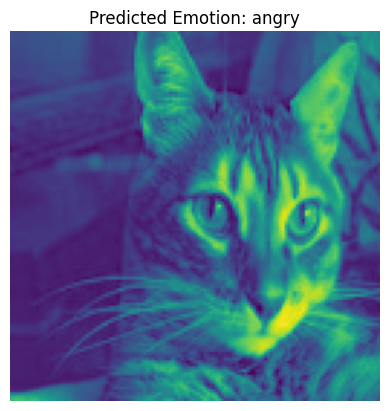

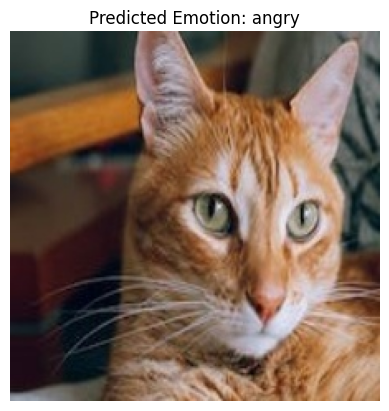

In [14]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("pet_facial_emotion_model.h5")

# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/master/test/Angry/39.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
# custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

In [16]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("pet_facial_emotion_model.h5")



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/master/happy/005.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
# custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

# Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

[ WARN:0@525.300] global loadsave.cpp:248 findDecoder imread_('pets_facial_expression_dataset/master/happy/011.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.1) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
from keras.models import load_model
# Load the saved model
loaded_model = load_model("pet_facial_emotion_model.h5")



# Function to load and preprocess images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size for the model
            images.append(img)
    return images


# Load a custom test image
custom_test_image_path = "pets_facial_expression_dataset/master/Sad/014.jpg"

custom_test_image = cv2.imread(custom_test_image_path)
# custom_test_image = cv2.cvtColor(custom_test_image, cv2.COLOR_BGR2GRAY)
custom_test_image = cv2.resize(custom_test_image, (128, 128))
custom_test_image = custom_test_image.astype('float32') / 255.0

# Reshape the image to match the model input shape
custom_test_image = np.expand_dims(custom_test_image, axis=0)
custom_test_image = np.expand_dims(custom_test_image, axis=-1)

# Make predictions on the custom test image
prediction = loaded_model.predict(custom_test_image)
prediction_prob = prediction[0]

emotion_label = np.argmax(prediction[0])

# Map the predicted label to emotion class
emotion_classes = {0: 'happy', 1: 'sad', 2: 'angry'}
predicted_emotion = emotion_classes[emotion_label]

# Print the custom test image and its predicted label
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence [happy, sad, angry]: {prediction_prob}")

import matplotlib.pyplot as plt

#Display the custom test image using matplotlib
plt.imshow(custom_test_image[0, :, :, 0])
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

from PIL import Image
# Display the original custom test image using PIL
img_pil = Image.open(custom_test_image_path)
plt.imshow(np.array(img_pil))
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  # Hide axes
plt.show()

